In [1]:
import us
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.holtwinters import ExponentialSmoothing

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 100
pd.options.display.min_rows = 200

from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

from IPython.core.display import display, HTML, display_html
display(HTML("<style>.container { width:100% !important; }</style>"))

# Load Data (downloaded from Google Drive)

In [2]:
pop_df = pd.read_csv("data/popdata.csv")
temp_df = pd.read_csv("data/tempdata.csv")

# Weather Station Name/Location Mapping
Used VIM to edit a file pulled from: https://www.ncdc.noaa.gov/data-access/land-based-station-data/station-metadata

There was a lot of data, so I needed to filter for only US stations

In [3]:
station_df = pd.read_csv("data/isd-history.txt")
for c in station_df:
    if station_df[c].dtype == object:
        station_df[c] = station_df[c].str.strip()
station_df.columns = [c.strip() for c in station_df]
station_df = station_df.query("CTRY == 'US'")

station_name_df = station_df.drop_duplicates("CALL")[["CALL", "ST", "LAT", "LON"]]

# Build the map between stations and coordinates

In [4]:
locs = temp_df[["name", "country_name", "station_code"]].drop_duplicates()
station_name_df["station_code"] = station_name_df["CALL"]
location_df = locs.merge(station_name_df, on="station_code", how="left").drop("CALL", axis=1)
location_df[["LAT", "LON"]] = location_df[["LAT", "LON"]].astype(float)

# Use Geopandas to perform math on coordinates

In [5]:
station_points = [Point(xy) for xy in zip(location_df["LON"], location_df["LAT"])]
station_df = gpd.GeoDataFrame(
    location_df,
    crs="EPSG:3395", # Mercator Projection
    geometry=station_points,
)

city_points = [Point(xy) for xy in zip(pop_df["Lon"], pop_df["Lat"])]
population_df = gpd.GeoDataFrame(
    pop_df,
    crs="EPSG:3395",
    geometry=city_points,
)

# Find the (weighted) population of a given region
There are many ways that you can do this, but my philosophy on problem solving is that simple solutions are better than complex ones. I find the N closest cities in the `population_df` table and compute the sum of the populations of each city. Then, I normalize the weights based on the values computed for each station. We should be able to play around with the number of cities we select, but I'm using `N=3` to start

In [6]:
N = 3
weighted_populations = []
for station_coords in station_df.geometry: 
    population_df["dist"] = 1 / (population_df.distance(station_coords))
    selected = population_df.sort_values("dist", ascending=False).head(N)
    # Potential more complex ideas here were to weight by distance or maybe search in a radius and do population/area as a metric
    weighted_populations.append(selected.population.sum())
station_df["weighted_population"] = weighted_populations
station_df["weight"] = station_df.weighted_population / station_df.weighted_population.sum()

## Print out the table to make sure this looks reasonable
Important to mix the quantitative big brain algos with more qualitative data validation checks

In [7]:
station_df.sort_values("weight", ascending=False).round(3)

,name,country_name,station_code,ST,LAT,LON,geometry,weighted_population,weight
20,NYC/LaGuardia,UnitedStates,KLGA,NY,40.779,-73.880,POINT (-73.88000 40.77900),8692632,0.169
9,Los Angeles,UnitedStates,KCQT,CA,34.024,-118.291,POINT (-118.29100 34.02400),4123277,0.080
6,Burbank,UnitedStates,KBUR,CA,34.201,-118.358,POINT (-118.35800 34.20100),4116905,0.080
25,Chicago O'Hare,UnitedStates,KORD,IL,41.960,-87.932,POINT (-87.93200 41.96000),2958997,0.058
18,Houston,UnitedStates,KIAH,TX,29.980,-95.360,POINT (-95.36000 29.98000),2415975,0.047
28,Phoenix/Sky HRBR,UnitedStates,KPHX,AZ,33.428,-112.004,POINT (-112.00400 33.42800),1873840,0.036
27,Philadelphia,UnitedStates,KPHL,PA,39.873,-75.227,POINT (-75.22700 39.87300),1781272,0.035
7,Baltimore,UnitedStates,KBWI,MD,39.173,-76.684,POINT (-76.68400 39.17300),1381790,0.027
11,Washington,UnitedStates,KDCA,VA,38.847,-77.035,POINT (-77.03500 38.84700),1381790,0.027
17,Wash DC/Dulles,UnitedStates,KIAD,VA,38.935,-77.447,POINT (-77.44700 38.93500),1381790,0.027


# Store a copy of `temp_df` for debugging/rerunning

In [8]:
raw_temp = temp_df.copy()

# Join our weights to the temperature data

In [9]:
temp_df = raw_temp.merge(station_df[["station_code", "weighted_population", "weight"]], on="station_code")
temp_df.location_date = pd.to_datetime(temp_df.location_date)
temp_df = temp_df.set_index("location_date").sort_index()

# Add the missing days to the table index
The plan is to run an linear interpolation on the data. A more sophisticated approach would be to use some sort of time series regression model to exploit the seasonality of weather (SARIMA), but we're not missing a whole lot of data, and this is much simpler, and probably more than 95% of the way there

In [10]:
all_days = pd.date_range(temp_df.index[0], temp_df.index[-1])
index_pairs = set([(day, station) for day in all_days for station in temp_df.station_code.unique()])
recorded_days = set(map(tuple, temp_df.reset_index()[["location_date", "station_code"]].drop_duplicates().values))
missing_data = list(index_pairs - recorded_days)
missing_data_df = pd.DataFrame(missing_data, columns=["location_date", "station_code"]).set_index(["location_date"])
temp_df = pd.concat((temp_df, missing_data_df)).reset_index().set_index("location_date").sort_index()

# Run the interpolation on each station

In [11]:
groups = []
for sta, g in temp_df.groupby("station_code"):
    g[["lerped_temp_min_c", "lerped_temp_mean_c", "lerped_temp_max_c"]] = g[["temp_min_c", "temp_mean_c", "temp_max_c"]].interpolate()
    g.weight = g.weight.ffill().bfill()
    g.weighted_population = g.weighted_population.ffill().bfill()
    groups.append(g)
temp_df = pd.concat(groups)

# Population Weighted Average Temperatures
The dotted black lines here show you the dates that were missing data

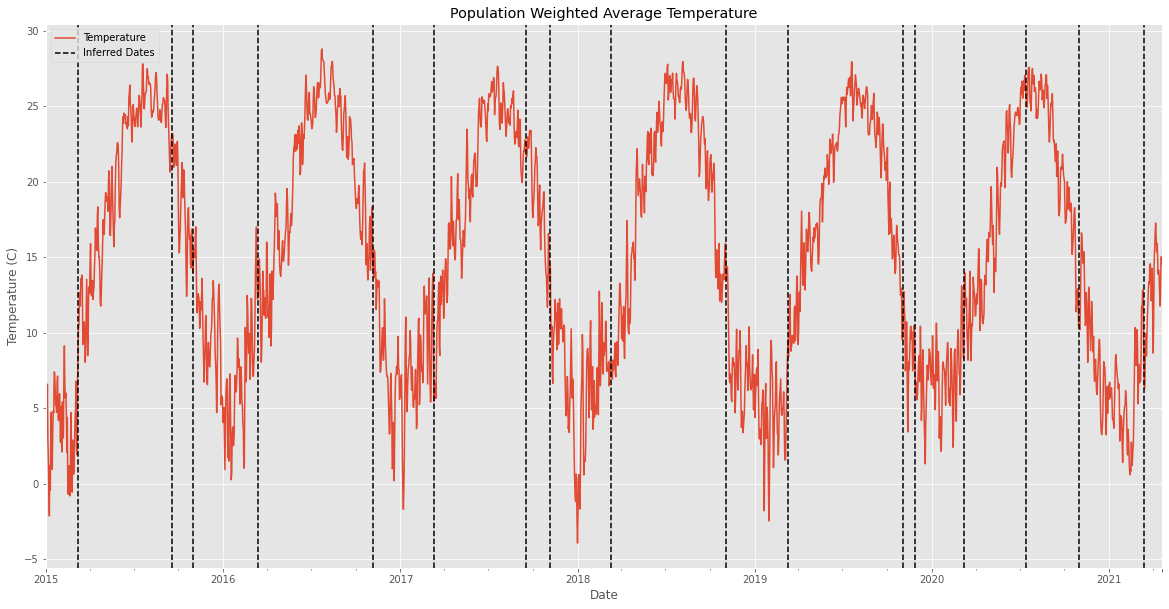

In [12]:
temp_df["lerped_weighted_temp"] = temp_df.eval("lerped_temp_mean_c * weight")
temp_df["weighted_temp"] = temp_df.eval("temp_mean_c * weight")
weighted_avg = temp_df.groupby("location_date")["weighted_temp"].sum()
lerped_weighted_avg = temp_df.groupby("location_date")["lerped_weighted_temp"].sum()
inferred_dates = lerped_weighted_avg.index[(weighted_avg - lerped_weighted_avg).abs() > 1]
lerped_weighted_avg.plot(figsize=(20, 10), label="Temperature")
for i, date in enumerate(inferred_dates):
    if i == 0:
        plt.axvline(date, color="black", linestyle="--", label="Inferred Dates")
    else:
        plt.axvline(date, color="black", linestyle="--")
plt.legend()
plt.ylabel("Temperature (C)")
plt.xlabel("Date")
plt.title("Population Weighted Average Temperature")
plt.show()

# Monthly Min/Max/Average
I'm going to skip the seasonal because I think this probably captures that in enough detail

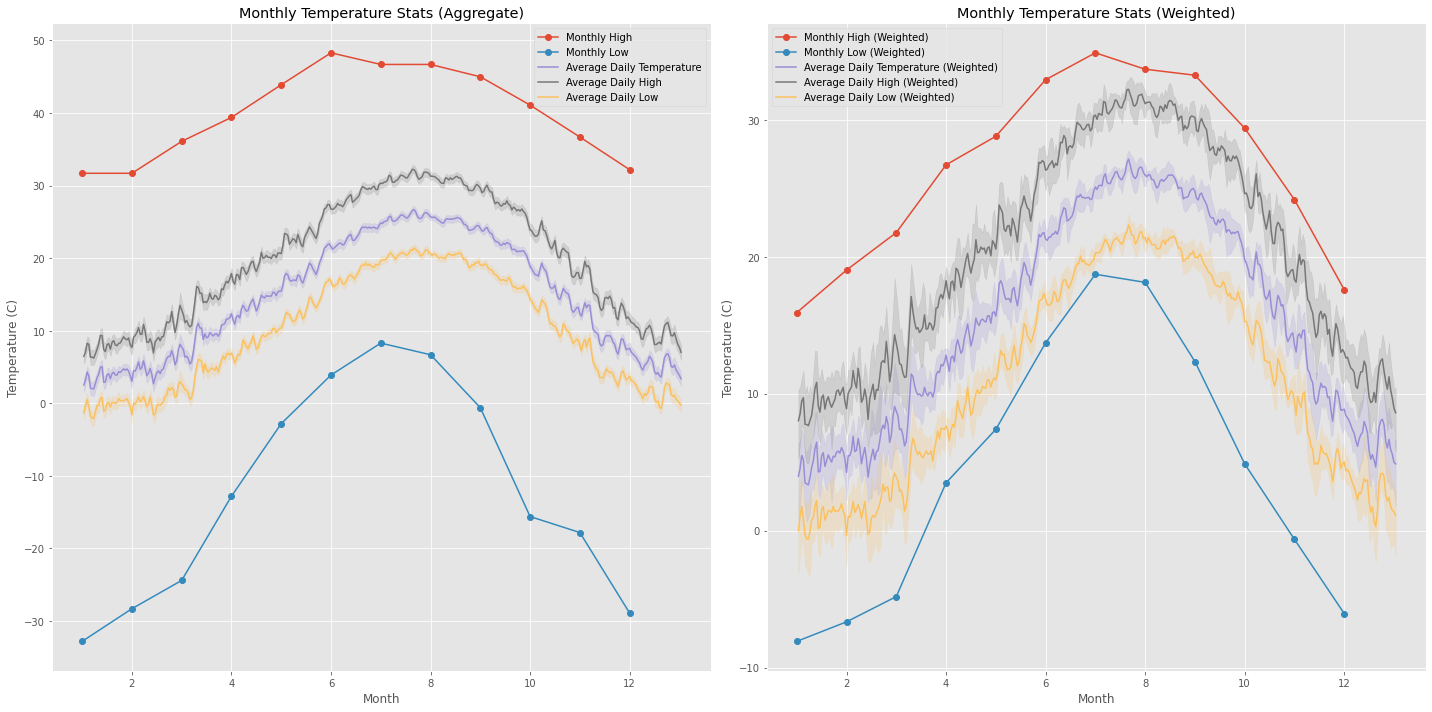

In [13]:
temp_df["lerped_weighted_temp"] = temp_df.eval("lerped_temp_mean_c * weight")
temp_df["lerped_weighted_temp_min"] = temp_df.eval("lerped_temp_min_c * weight")
temp_df["lerped_weighted_temp_max"] = temp_df.eval("lerped_temp_max_c * weight")
aggregated_temp_df = temp_df.groupby("location_date")[["lerped_weighted_temp", "lerped_weighted_temp_max", "lerped_weighted_temp_min"]].sum()
aggregated_temp_df["month"] = aggregated_temp_df.index.month
aggregated_temp_df["day"] = aggregated_temp_df.index.day
aggregated_temp_df["normalized_day"] = aggregated_temp_df.eval("month + day/30")

temp_df["weighted_temp"] = temp_df.eval("temp_mean_c * weight")
temp_df["month"] = temp_df.index.month
temp_df["day"] = temp_df.index.day
temp_df["normalized_day"] = temp_df.eval("month + day/30")

lerped_weighted_avg = temp_df.groupby("location_date")["lerped_weighted_temp"].sum()
monthly_high = temp_df.groupby("month")["lerped_temp_max_c"].max()
monthly_low = temp_df.groupby("month")["lerped_temp_min_c"].min()
weighted_monthly_high = aggregated_temp_df.groupby("month")["lerped_weighted_temp_max"].max()
weighted_monthly_low = aggregated_temp_df.groupby("month")["lerped_weighted_temp_min"].min()

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax = ax.flatten()
a = ax[0]
monthly_high.plot(marker="o", ax=a, label="Monthly High")
monthly_low.plot(marker="o", ax=a, label="Monthly Low")
sns.lineplot(x="normalized_day", y="temp_mean_c", data=temp_df, ax=a, label="Average Daily Temperature")
sns.lineplot(x="normalized_day", y="temp_max_c", data=temp_df, ax=a, label="Average Daily High")
sns.lineplot(x="normalized_day", y="temp_min_c", data=temp_df, ax=a, label="Average Daily Low")
a.set_xlabel("Month")
a.set_ylabel("Temperature (C)")
a.set_title("Monthly Temperature Stats (Aggregate)")
a = ax[1]
weighted_monthly_high.plot(marker="o", ax=a, label="Monthly High (Weighted)")
weighted_monthly_low.plot(marker="o", ax=a, label="Monthly Low (Weighted)")
sns.lineplot(x="normalized_day", y="lerped_weighted_temp", data=aggregated_temp_df, ax=a, label="Average Daily Temperature (Weighted)")
sns.lineplot(x="normalized_day", y="lerped_weighted_temp_max", data=aggregated_temp_df, ax=a, label="Average Daily High (Weighted)")
sns.lineplot(x="normalized_day", y="lerped_weighted_temp_min", data=aggregated_temp_df, ax=a, label="Average Daily Low (Weighted)")
a.set_xlabel("Month")
a.set_ylabel("Temperature (C)")
a.set_title("Monthly Temperature Stats (Weighted)")
plt.tight_layout()
plt.show()


# Fit an Exponential Smoothing model to predict future temperatures

In [14]:
model = ExponentialSmoothing(aggregated_temp_df.sort_index().lerped_weighted_temp.tolist(), trend="add", seasonal="add", seasonal_periods=365)
mfit = model.fit()

/Users/jarryxiao/Projects/bill-perkins-twitter-challenge/venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


# Plot the data from the model

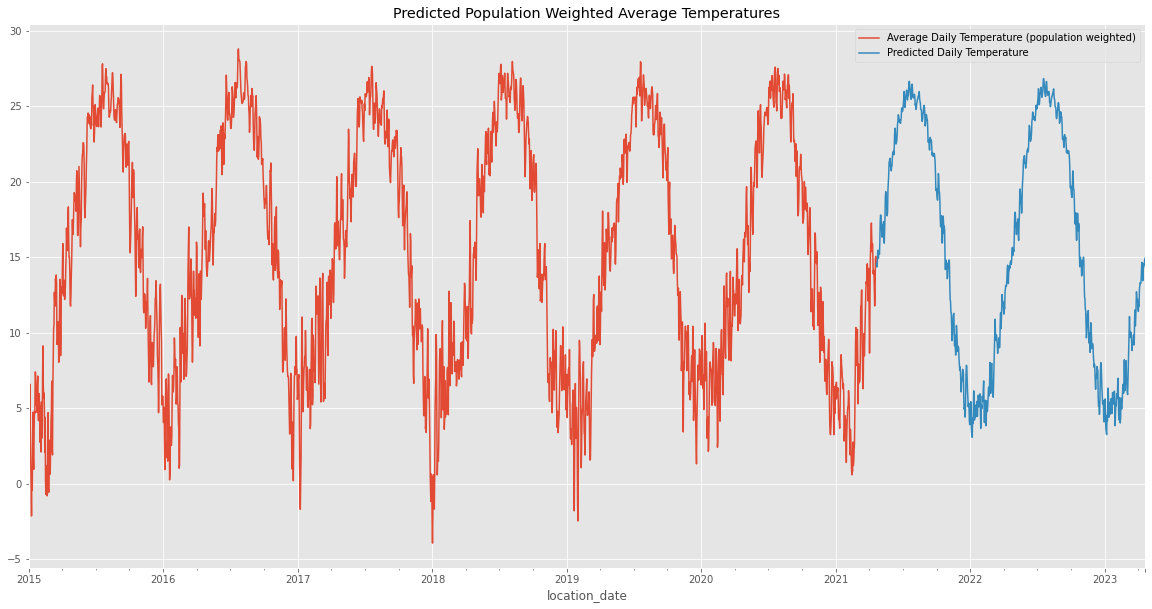

In [15]:
YEARS = 2
data = aggregated_temp_df.sort_index().lerped_weighted_temp
ax = data.plot(figsize=(20, 10), label="Average Daily Temperature (population weighted)")
future_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), data.index[-1] + pd.Timedelta(days=365 * YEARS))
ax.set_xlim([data.index[0], future_dates[-1]])
ax.plot(future_dates, mfit.forecast(365 * YEARS), label="Predicted Daily Temperature")
plt.legend()
plt.title("Predicted Population Weighted Average Temperatures")
plt.show()